In [257]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

In [258]:
def read_spe(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
        bins = np.array(list(map(lambda x: float(x.strip()), lines[12:-16])))

    for i in range(len(lines) - 1, -1, -1):
        if lines[i].startswith("$ENER_FIT"):
            bin_width = float(lines[i+1].strip().split(" ")[-1])
            break

    return bins, bin_width

def gaussian(x, a, mu, sigma):
    return a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

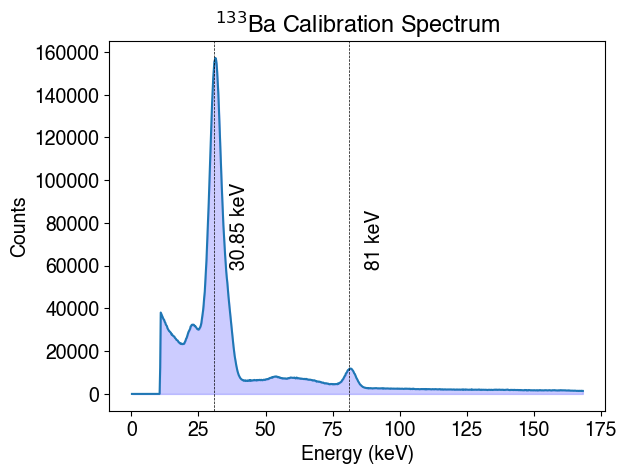

In [259]:
def plot_mca(filename):
    bins, bin_width = read_spe(filename)
    y = bins[:800]
    x = np.arange(y.size) * bin_width + bin_width

    # Fill underneath the curve
    plt.fill_between(x, y, color="blue", alpha=0.2)

    plt.plot(x, y)

    plt.xlabel("Energy (keV)")
    plt.ylabel("Counts")

    plt.axvline(x=30.85, color="black", linestyle="--", linewidth=0.5)
    plt.axvline(x=81, color="black", linestyle="--", linewidth=0.5)

    plt.annotate("30.85 keV", (30.85 + 6, 60000), color="black", rotation=90)
    plt.annotate("81 keV", (81 + 6, 60000), color="black", rotation=90)

    plt.title("$^{133}$Ba Calibration Spectrum")
    plt.rcParams.update({'font.size': 14, 'font.family': 'Helvetica'})

    plt.savefig("calibration.pdf", bbox_inches='tight', pad_inches=0.01)
    plt.show()
plot_mca("data/calibration.Spe")

popt [3150.94653975   29.04550725    3.34889   ]
Delta v=sigma/mu/2/2 0.02882450950275306


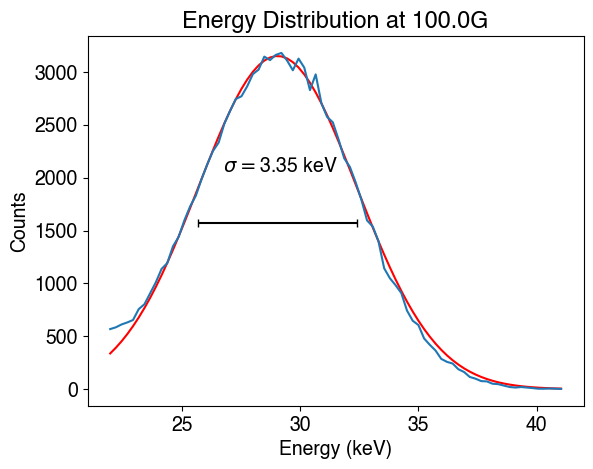

In [260]:
# for filename in ["data/80.Spe", "data/85.Spe", "data/90.Spe", "data/95.Spe", "data/rel_100G.Spe", "data/105.Spe", "data/110.Spe"]:
filename = "data/rel_100G.Spe"
# Find standard deviation of the peaks we care about
bins, bin_width = read_spe(filename)
y = bins[90:170]
x = (90+np.arange(y.size)) * bin_width + bin_width

popt, pcov = curve_fit(f=gaussian, xdata=x, ydata=y, sigma=1./np.sqrt(y), p0=[3000, 9, 4])
sigma = np.sqrt(np.diag(pcov))

print("popt", popt)

plt.plot(x, gaussian(x, *popt), color="red")
plt.errorbar(popt[1], popt[0] / 2., xerr=popt[2], fmt="none", color="black", capsize=3)
plt.annotate("$\\sigma=$" + str(round(popt[2], 2)) + " keV", (popt[1] - 2.3, popt[0] / 3. + 1000), color="black")

print("Delta v=sigma/mu/2/2", popt[2] / popt[1] / 2 / 2) # One-sided, sqrt relationship with energy

predicted = gaussian(x, *popt)
chi2 = np.sum((y - predicted)**2 / y) / (y.size - 4)
# plt.annotate("\u03C7\u00b2=" + str(round(chi2, 2)), (26.8, 1000), color="black")

plt.plot(x, y)
plt.title("Energy Distribution at 100.0G")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.savefig("resolution.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

In [261]:
bins[100:150]

array([1192., 1351., 1441., 1597., 1728., 1829., 1985., 2125., 2252.,
       2332., 2511., 2631., 2744., 2770., 2864., 2980., 3022., 3145.,
       3112., 3161., 3180., 3107., 3016., 3126., 3041., 2828., 2977.,
       2705., 2575., 2524., 2363., 2183., 2101., 1957., 1793., 1596.,
       1538., 1399., 1143., 1049.,  983.,  909.,  743.,  647.,  606.,
        479.,  419.,  365.,  286.,  258.])

In [262]:
peak = bins[148]

Relative uncertainty in max voltage:  0.09420289855072457
Max voltage:  1.38
Relative uncertainty in max voltage:  0.05434782608695653
Max voltage:  2.3
Relative uncertainty in max voltage:  0.025862068965517227
Max voltage:  2.9
Relative uncertainty in max voltage:  0.06578947368421052
Max voltage:  3.8
Relative uncertainty in max voltage:  0.1764705882352941
Max voltage:  5.1


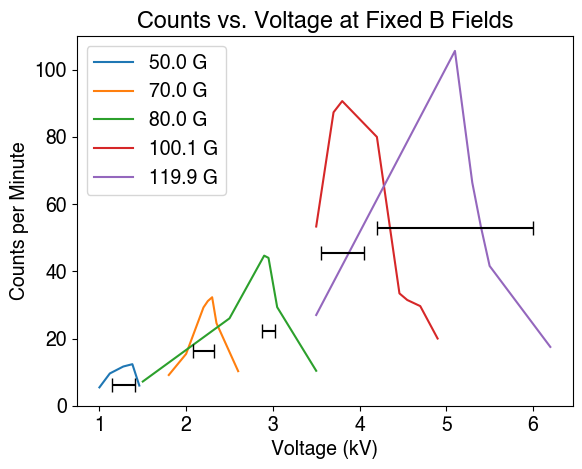

In [263]:
m = 9.1094e-28 # g
c = 3.0e10 # cm/s
d = 0.18 # cm
e = 4.803e-10 # ?
rho = 20.3 # cm
l = 10.0 # cm
I = np.array([ # Amperes
    2.32,
    3.03,
    3.69,
    4.61,
    5.34
])
B = np.array([ # Gauss
    50.0,
    70.0,
    80.0,
    100.1,
    119.9
])
V = [ # Volts
    np.array([1.00, 1.12, 1.275, 1.38, 1.46]),
    np.array([1.8, 2.0, 2.2, 2.25, 2.3, 2.35, 2.6]),
    np.array([1.5, 2.50, 2.90, 2.95, 3.05, 3.50]),
    np.array([3.50, 3.70, 3.80, 4.20, 4.46, 4.55, 4.70, 4.90]),
    np.array([3.5, 5.1, 5.3, 5.4, 5.5, 6.2])
]
V_statvolts = V * 300
total_counts = [
    np.array([15.0, 24.0, 35.0, 34.0, 18.0]),
    np.array([32, 54, 117, 109, 113, 86, 36]),
    np.array([18, 65, 67, 88, 44, 26]),
    np.array([80.0, 131.0, 136.0, 120.0, 117.0, 118.0, 126.0,  70.0]),
    np.array([54, 264, 166, 133, 104, 35])
]
minutes = [
    np.array([2.75, 2.5, 3.0, 2.75, 3.0]),
    np.array([3.5, 3.5, 4.0, 3.5, 3.5, 3.5, 3.5]),
    np.array([2.5, 2.5, 1.5, 2.0, 1.5, 2.5]),
    np.array([1.5, 1.5, 1.5, 1.5, 3.5, 3.75, 4.25, 3.5]),
    np.array([2.0, 2.5, 2.5, 2.5, 2.5, 2.0])
]

counts_per_minute = []
for i in range(len(I)):
    counts_per_minute.append(total_counts[i] / minutes[i])

# peak_E = np.array([
#     [],
#.     187.69 ish
#     [271.04, 274.16, 274.99, 273.53, 0, 0, 271.87, 274.99]
# ])
for i in range(len(V)):
    plt.plot(V[i], counts_per_minute[i])

max_x = []
max_y = []
y_lim_max = 110
plt.ylim(0, y_lim_max)
for i in range(len(V)):
    max_x.append(V[i][np.argmax(counts_per_minute[i])])
    max_y.append(np.max(counts_per_minute[i]))
    err = (V[i][total_counts[i].argmax() + 1] - V[i][total_counts[i].argmax() - 1]) / 2.0
    plt.errorbar(V[i][total_counts[i].argmax()], max_y[i]/2, xerr=err, color="black", capsize=5, capthick=1)
    print("Relative uncertainty in max voltage: ", err / max_x[i])
    print("Max voltage: ", max_x[i])


    # plt.annotate(f"{max_x[i]:.2f} kV", (max_x[i] + 0.1, min(80, max_y[i] + 5)), color="black", rotation=90)
    # plt.axvline(x=max_x[i], ymax=max_y[i] / y_lim_max, color="black", linestyle="--", linewidth=0.5)

# plt.plot(max_x, max_y, color="black")

plt.legend([f"{B[i]} G" for i in range(len(B))])
plt.xlabel("Voltage (kV)")
plt.ylabel("Counts per Minute")
plt.title("Counts vs. Voltage at Fixed B Fields")
plt.savefig("counts_vs_voltage.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

In [264]:
# Expected maximum voltage (tells expected velocity of the electron)

def relativistic_expected_voltage(B):
    B_p = B / 10000.
    V = B_p*d/np.sqrt(1/c**2+(m/(e*B_p*rho))**2)
    return V / 1000.

def classical_expected_voltage(B):
    B_p = B / 10000.
    V = B_p*d
    return V / 1000.

Relative uncertainty:  2.0439435217578246 %


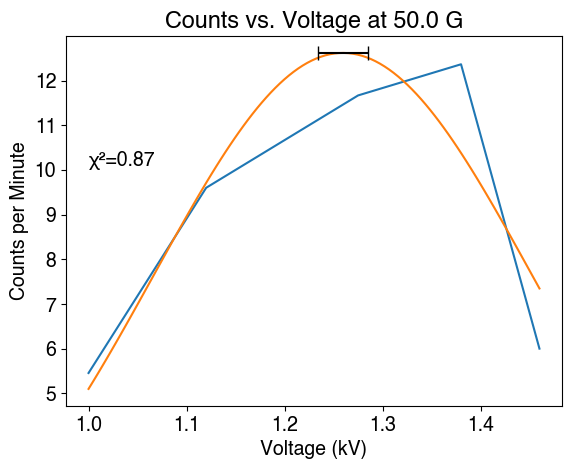

...... 0.08620949188062511
Relative uncertainty:  1.1414338248934046 %


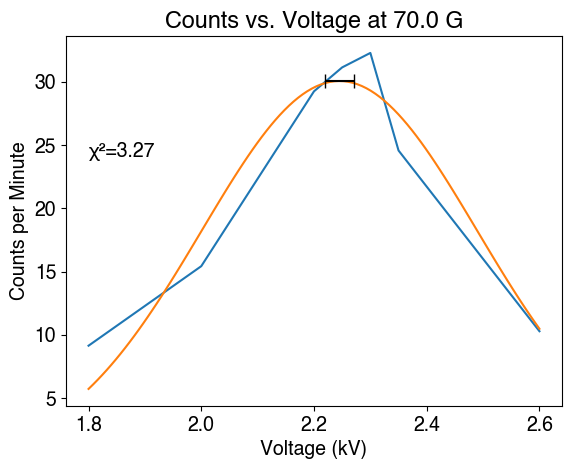

...... -0.09238124249629716
Relative uncertainty:  2.1095279778176814 %


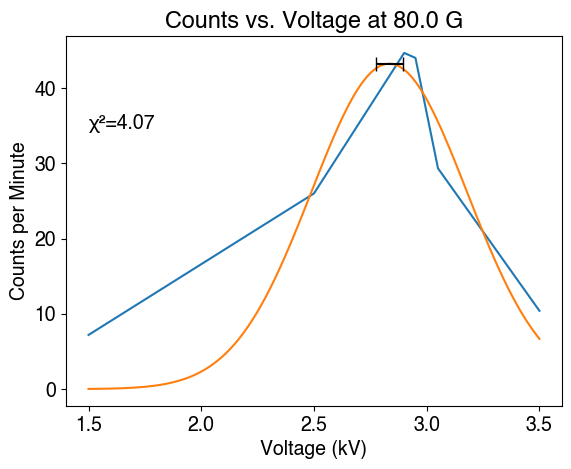

...... -0.1407402925141425
Relative uncertainty:  1.0415188622456222 %


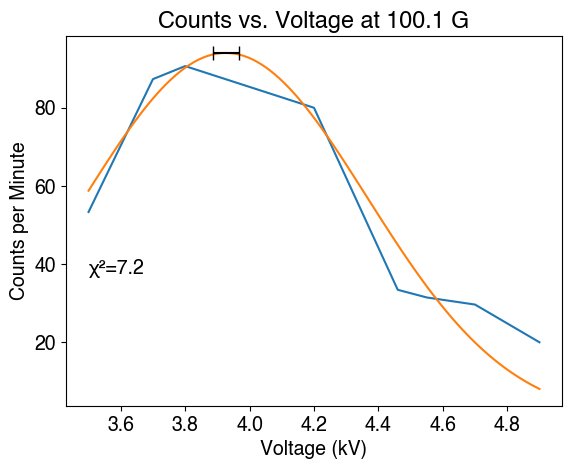

...... -0.15536514320492767
Relative uncertainty:  1.2583485807424621 %


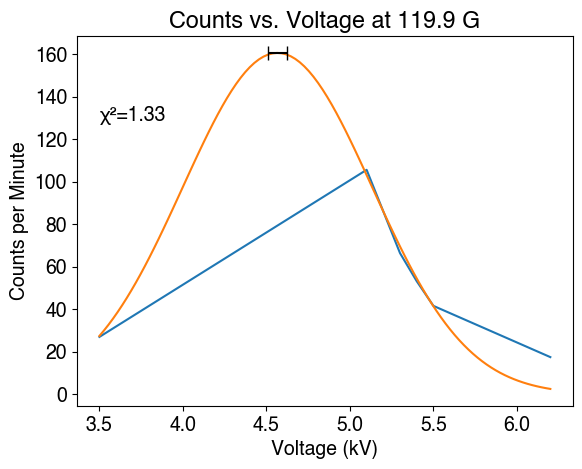

...... -0.23157282000477375


In [265]:
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

def fit_to_n_versus_b(i, func=gaussian):
    plt.plot(V[i], counts_per_minute[i])

    max_counts = np.max(counts_per_minute[i])
    max_voltage = V[i][np.argmax(counts_per_minute[i])]
    v_range = V[i][-1] - V[i][0]
    popt, pcov = curve_fit(f=func, xdata=V[i], ydata=counts_per_minute[i], p0=[max_counts, max_voltage, v_range])
    # popt, pcov = curve_fit(f=func, xdata=V[i], ydata=counts_per_minute[i], p0=[-0.1, 0, 30])
    sigma = np.sqrt(np.diag(pcov))
    x = np.linspace(V[i][0], V[i][-1], 100)
    y = func(x, *popt)
    plt.plot(x, y)

    predicted = func(V[i], *popt)
    chi2 = np.sum((counts_per_minute[i] - predicted)**2/sigma[0]) / V[i].size
    chi2_y_pos = popt[0] * 0.8 if i != 3 else popt[0] * 0.4
    plt.annotate("\u03C7\u00b2=" + str(round(chi2, 2)), (V[i][0], chi2_y_pos), color="black")

    plt.errorbar(popt[1], popt[0], xerr=sigma[1], color="black", capsize=5, capthick=1)
    print("Relative uncertainty: ", sigma[1] / popt[1] * 100, "%")

    plt.title(f"Counts vs. Voltage at {B[i]} G")
    plt.xlabel("Voltage (kV)")
    plt.ylabel("Counts per Minute")

    plt.savefig(f"counts_vs_voltage_{i}.pdf", bbox_inches='tight', pad_inches=0.01)

    plt.show()

    # print("params: ", popt)

    return popt, pcov

for i in range(len(V)):
    popt, pcov = fit_to_n_versus_b(i, gaussian)
    sigma_V = popt[2]
    # Use first uncert for fit, second for velocity
    uncert_V = sigma_V / np.sqrt(V[i].size) # V[i][np.argmax(counts_per_minute[i])]
    print("......", uncert_V)

# plt.plot(B, V[:, np.argmax(counts_per_minute, axis=0)])
# plt.show()

In [266]:
m = 9.1094e-28 # g
c = 3.0e10 # cm/s
d = 0.18 # cm
e = 4.803e-10 # ?
rho = 20.3 # cm
l = 10.0 # cm
# Calculate the expected velocity range of detector
i = 3
# voltage = V_statvolts[i][np.argmax(counts_per_minute[i])]
voltage = (np.array([V[i][total_counts[i].argmax()] for i in range(len(B))]) * 0.003336 * 1000)[i]
u_0 = voltage / d / B[i]
qa = 4*m*d/(e*l**2)
qb = B[i]#*3e-6
qc = -voltage / d

print(qa, qb, qc)

print("solve 6.8e-21*x^2 +50x -7.66")
print(f"x = 0.1532")
print("Expected velocities: ", u_0)
print("Relative error in velocity: ", (u_0 - 0.70356) / u_0)

1.3655565271705183e-20 100.1 -70.42666666666668
solve 6.8e-21*x^2 +50x -7.66
x = 0.1532
Expected velocities:  0.7035631035631037
Relative error in velocity:  4.411207876048384e-06


In [267]:
# Relativistic expected max velocity
i = 0
E = V_statvolts[i][np.argmax(counts_per_minute[i])] / d
u3 = l**2*B[i]
u2 = -l**2*E - 2*m*d/e
u1 = -l**2*B[i]
u0 = l**2*E
print(2*m*d/e*c*100)
print(u3, u2, u1, u0)
print("solve 5000x^3 -766x^2 - 5000x +766 = 0")
print(f"x = {383 / 2500 = }")

2.048334790755777e-06
5000.0 -766.6666666666666 -5000.0 766.6666666666666
solve 5000x^3 -766x^2 - 5000x +766 = 0
x = 383 / 2500 = 0.1532


In [268]:
def gamma(v):
    return 1.0/np.sqrt(1.0 - np.square(v)/np.square(c))

def ke_vs(B, V):
    E = V / d
    v = E / B
    return m*np.square(c)*(gamma(v) - 1.0)

def G2Tesla(B):
    return B / 10000.0

def J2keV(a):
    return a / 1.6e-16

# print(J2keV(ke_vs(G2Tesla(100.0), 4130.)))

def ke_cyc(B):
    p = B*e*rho
    return m*np.square(c)*(np.sqrt(1.0 + np.square(p/(m*c))) - 1.0)

print(J2keV(ke_cyc(G2Tesla(70.))))

1.2796988000963526e+16


[ 4.2534  7.3392  9.8412 12.6768 17.0136]
BBBB:  0.043664658830240045
[0.10196078 0.05681818 0.02542373 0.06578947 0.17647059] [0.13778971 0.08241027 0.04781681 0.08368604 0.19141176]
aojwoifiofj [0.4726     0.58247619 0.68341667 0.7035631  0.7883236 ]
0.16396113984508973
10.448823382502553


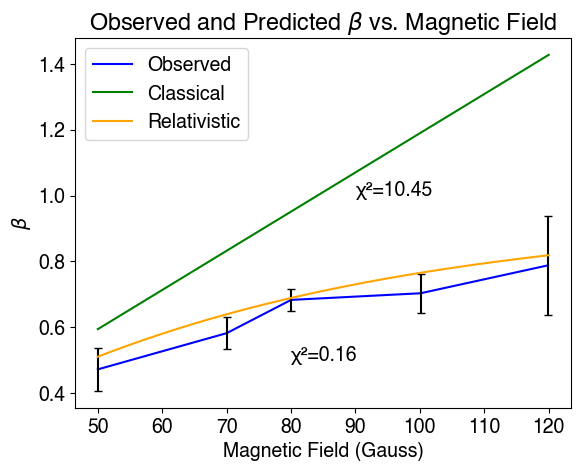

In [269]:
observed_V_0 = np.array([V[i][total_counts[i].argmax()] for i in range(len(B))]) * 0.003336 * 1000 # Conversion to statavolts
print(observed_V_0)
relative_uncert_obs_V_0 = np.array([
    (V[i][total_counts[i].argmax() + 1] - V[i][total_counts[i].argmax() - 1]) / 2.0 / V[i][total_counts[i].argmax()]
    for i in range(len(B))
])
E_obs = observed_V_0 / d
rho = 20.3
Bs = np.array([92.3, 86.6, 88.2, 97.8, 93.8])
print("BBBB: ", Bs.std()/Bs.mean())
relative_uncert_B = np.std(Bs) / np.sqrt(Bs.size) / B
relative_uncert_beta = relative_uncert_obs_V_0 + relative_uncert_B
print(relative_uncert_obs_V_0, relative_uncert_beta)
x = np.linspace(50, 120, 1000)

# Observed
def obs_beta(B):
    return E_obs / B
plt.plot(B, obs_beta(B), color="blue")
print("aojwoifiofj", obs_beta(B))
plt.errorbar(B, obs_beta(B), yerr=relative_uncert_beta * obs_beta(B), fmt='none', color="black", capsize=3)

# Classical Prediction
def classical_beta(B, em):
    # return em * rho / c**2 * B
    # return 0.011 * B
    return em * rho / c**2 * B
plt.plot(x, classical_beta(x, e/m), color="green")

# Relativistic Prediction
def relativistic_beta(B, e_m):
    return 1./np.sqrt(np.square((c**2)/(e_m * rho * B)) + 1.)

def relativistic_beta(B, e_m):
    return 1./np.sqrt((c**2/(e_m*rho))**2/np.square((B)) + 1.)

plt.plot(x, relativistic_beta(x, e/m), color="orange")

# Classical Best Fit
def line(x, m):
    return m*x
sigma_obs = obs_beta(B)
popt_classical, pcov_classical = curve_fit(f=line, xdata=B, ydata=obs_beta(B), sigma=sigma_obs, p0=[1], absolute_sigma=True)
sigma_fit_classical = np.sqrt(np.diag(pcov_classical))
# plt.plot(x, line(x, *popt_classical))

# Relativistic Best Fit
popt_rel, pcov_rel = curve_fit(f=relativistic_beta, xdata=B, ydata=obs_beta(B), sigma=sigma_obs, p0=[e/m], absolute_sigma=True)
sigma_fit_rel = np.sqrt(np.diag(pcov_rel))
# plt.plot(x, relativistic_beta(x, *popt_rel))


predicted = relativistic_beta(B, e/m)
chi2 = np.sum((obs_beta(B) - predicted)**2/relative_uncert_beta/obs_beta(B))
print(chi2)
plt.annotate("\u03C7\u00b2=" + str(round(chi2, 2)), (80, 0.5), color="black")

predicted = classical_beta(B, e/m)
chi2 = np.sum((obs_beta(B) - predicted)**2/relative_uncert_beta/obs_beta(B))
print(chi2)
plt.annotate("\u03C7\u00b2=" + str(round(chi2, 2)), (90, 1.0), color="black")

plt.legend(["Observed", "Classical" , "Relativistic"])

plt.xlabel("Magnetic Field (Gauss)")
plt.ylabel("$\\beta$")
plt.title("Observed and Predicted $\\beta$ vs. Magnetic Field")
plt.savefig("beta_vs_B.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

1.7397016445550035
27.742812201271256


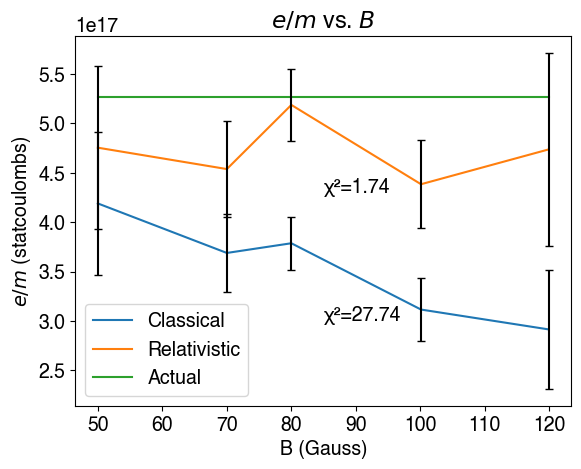

In [270]:
def e_m_from_B_classical(B, E):
    return 1./(np.square(B) * rho / (E * c**2))

relative_uncert_e_m_classical = 2 * relative_uncert_B + relative_uncert_obs_V_0

def e_m_from_B_rel(B ,E):
    return E/np.square(B) * 1./np.sqrt(1. - np.square(E/B)) * c**2 / rho

relative_uncert_e_m_relativistic = 2 * relative_uncert_B + relative_uncert_obs_V_0 # TODO: Not right, take into account gamma

y_cls = e_m_from_B_classical(B, E_obs)
plt.plot(B, y_cls)

y_rel = e_m_from_B_rel(B, E_obs)
plt.plot(B, y_rel)

actual = e/m * np.ones(B.size)
plt.plot(B, actual)

plt.errorbar(B, y_cls, yerr=relative_uncert_e_m_classical * y_cls, capsize=3, fmt="none", color="black")
plt.errorbar(B, y_rel, yerr=relative_uncert_e_m_relativistic * y_rel, capsize=3, fmt="none", color="black")


chi2 = np.sum((y_rel - actual)**2/(relative_uncert_e_m_relativistic*y_rel)**2) / 4.
print(chi2)
plt.annotate("\u03C7\u00b2=" + str(round(chi2, 2)), (85, 4.3e17), color="black")

chi2 = np.sum((y_cls - actual)**2/(relative_uncert_e_m_classical*y_cls)**2) / 4.
print(chi2)
plt.annotate("\u03C7\u00b2=" + str(round(chi2, 2)), (85, 3.0e17), color="black")

plt.legend(["Classical", "Relativistic", "Actual"])
plt.title("$e/m$ vs. $B$")
plt.xlabel("B (Gauss)")
plt.ylabel("$e/m$ (statcoulombs)")
plt.savefig("e_m_vs_B.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

In [271]:
m = 9.11e-28 # kg # eV, g
c = 3.0e10 # m/s
d = 0.18 # m
e = 1.6e-19
def gamma(v):
    return 1.0/np.sqrt(1.0 - np.square(v)/np.square(c))

def ke(B, V):
    E = V / d
    v = E*c / B 
    return m*np.square(c)*(gamma(v) - 1.0)

def G2Tesla(B):
    return B / 10000.0

def J2keV(a):
    return a / 1.6e-16

J2keV(ke(80, 3500. / 300)) / 1e7

361.7696372309184

In [272]:
Bs = [92.3, 86.6, 88.2, 97.8, 93.8]
np.std(Bs) / np.sqrt(np.mean(Bs))

0.41822446963088844